In [1]:
# Set Jupyter Notebook style
from IPython.display import display, HTML
display(HTML('<style>.jp-Cell { width: 100% !important;}\
             .jp-CodeCell {margin: 0px 0px 20px 0px !important;}\
             .jp-RenderedHTMLCommon h1 {color: #3a7fa1; font-weight: 500 !important; font-size: 44px !important;}\
             .jp-RenderedHTMLCommon h2, h3, h4 {color: #5298ba; font-weight: 500 !important; font-size: 32px !important;}\
             .jp-RenderedHTMLCommon h3 {color: #5b9eb0; font-size: 28px !important;}\
             .jp-RenderedHTMLCommon h4 {color: #5b9eb0; font-size: 22px !important;}\
             </style>'))

### Import modules

In [2]:
# fundamentals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectPercentile
from imblearn.over_sampling import SMOTE


# pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Evaluation, optimization, metrics
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance

# custom
from global_settings import *
from functions import *

### Load dev dataset, drop duplicates and split

In [3]:
data = pd.read_csv('../Data/HR_Analytics.csv')

data = data.drop_duplicates()
data['Attrition'] = data["Attrition"].replace({'Yes': 1, 'No': 0})



Xtrain, Xtest, ytrain, ytest = train_test_split(data.drop('Attrition', axis=1), 
                                                data['Attrition'], 
                                                test_size=0.2, 
                                                shuffle=True,
                                                stratify=data['Attrition'], 
                                                random_state=random_seed_split)

### Group columns

In [4]:
# Assign columns to column groups
nominal_cats = ['AgeGroup', 'SalarySlab', 'Department', 'EducationField', 'JobRole', 'MaritalStatus', 'OverTime', 'Gender']
ordinal_cats = ['BusinessTravel']
numericals = ['Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 
           'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance', 'Age', 'DailyRate', 'DistanceFromHome', 
           'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 
           'TrainingTimesLastYear', 'AvgYearsAtEachEmployer']
pcacols = ['YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

### Prepare preprocessing

In [5]:
def avg_stay_at_company(df):
    '''
    Add a column stating the employee's average duration at their previous eomployers.
    ARGS: df (DataFrame): Feature data
    RETURNS: Updated feature data
    '''
    df.loc[:,'AvgYearsAtEachEmployer'] = df.loc[:,'TotalWorkingYears'] / (df.loc[:,'NumCompaniesWorked'] + 1)
    return df

def clean_data(df):
    '''
    Clean data
    ARGS: df (DataFrame): Feature data
    RETURNS: DataFrame: Edited feature data
    '''
    df = df.replace({'TravelRarely': 'Travel_Rarely'})
    return df

def quadrants(df):
    '''
    Create a categorical column grouping the employees by their "MonthlyIncome over TotalWorkingYears quadrant"
    ARGS: df (DataFrame): Feature data
    RETURNS: DataFrame: Updated feature data
    '''
    def assign_quadrant(twy, mi):
        if mi < 10000:
            if twy < 20.5:
                return 'LowXP_LowInc'
            else:
                return 'HighXP_LowInc'
        else:
            if twy < 20.5:
                return 'LowXP_HighInc'
            else:
                return 'HighXP_HighInc'
    quads = [assign_quadrant(twy, mi) for twy, mi in zip(df['TotalWorkingYears'], df['MonthlyIncome'])]
    df.loc[:,'XP_Inc_Quadrant'] = quads
    return df

### Prepare pipelines

In [6]:
# Custom transformers
cleaner = FunctionTransformer(clean_data)
avgstay = FunctionTransformer(avg_stay_at_company)
quadrant = FunctionTransformer(quadrants)

# Predefined transformers
onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)
simpimp = SimpleImputer(strategy='median')
scaler = StandardScaler()
pca = PCA(n_components=2)
ordinal_encoder = OrdinalEncoder(categories=[['Non-Travel', 'Travel_Rarely', 'Travel_Frequently']], 
                               dtype=int, 
                               handle_unknown='use_encoded_value', 
                               unknown_value=-1, 
                               encoded_missing_value=3)

# Transformer pipelines
preprep = Pipeline([('cleaner', cleaner),
                    ('avgstay', avgstay),
                    ('quadrant', quadrant)])
catpipe = Pipeline([('encoder', onehot)])
numpipe = Pipeline([('imputer', simpimp),
                    ('scaler', scaler)])
pcapipe = Pipeline([('imputer', simpimp),
                    ('scaler', scaler),
                    ('pca', pca)])

# Diverging column treatment
coltrans = ColumnTransformer(transformers=[('encoder', catpipe, nominal_cats),
                                           ('ordencoder', ordinal_encoder, ordinal_cats),
                                           ('numpipe', numpipe, numericals),
                                           ('pcapipe', pcapipe, pcacols)])

# Preprocessing pipeline
prepper = Pipeline([('preprep', preprep),
                    ('coltrans', coltrans)])

# Automated feature selection (black box)
selection = SelectPercentile(percentile=90) # percentile=10

### Import available models and settings

In [7]:
from models import *
print(f'Models that are available: {list(model_settings.keys())}')

Models that are available: ['log', 'svc', 'xgb', 'rfc']


## Choose model

In [8]:
chosen_model = 'log'
# Define models and params / search space in models.py

### Prepare grid search

In [9]:
model = model_settings[chosen_model]['model']
search_space = model_settings[chosen_model]['params']

# Outcomment search_space and 'selector' if SelectPercentile is not to be applied
#search_space['selector__percentile'] = [70, 75, 80, 85, 90, 95, 100]
pipe = Pipeline([('prepper', prepper),
#                 ('selector', selection),
                 ('estimator', model)])

### Run grid search

Fitting 6 folds for each of 1 candidates, totalling 6 fits


C:\Users\osmin\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


{}
Best F2 score: 64.95%
--------------------------------------------------------
F2 score on test set:	70.14%
Recall on test set:	82.98%
Precision on test set:	43.33%


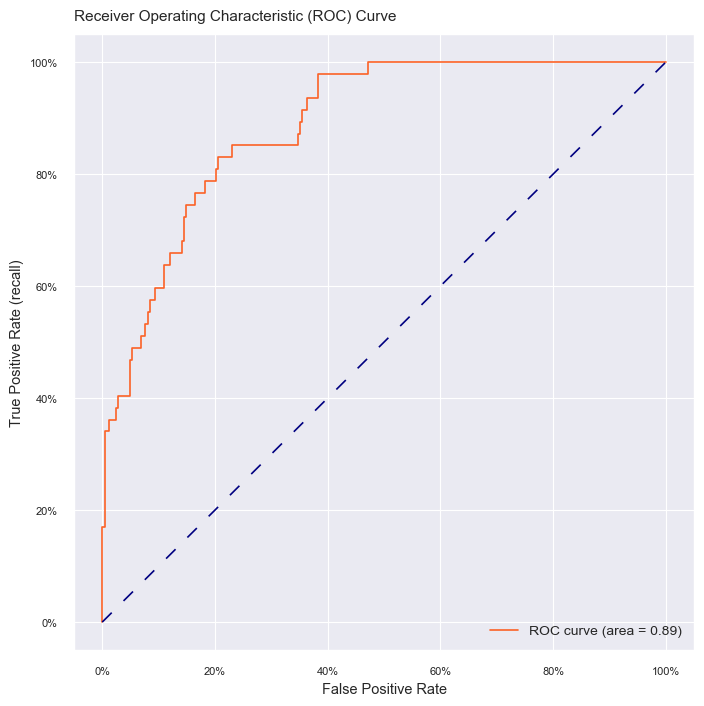

In [10]:
best_pipe = GridSearchCV(estimator=pipe,
                         param_grid=search_space,
                         scoring=f2(),
                         cv=6,
                         verbose=3,
                         n_jobs=-1)
best_pipe.fit(Xtrain, ytrain)
print(best_pipe.best_params_)
print(f'Best F2 score: {best_pipe.best_score_.mean():.2%}')
print('--------------------------------------------------------')
ypred = best_pipe.predict(Xtest)
print(f'F2 score on test set:\t{f2_score(ytest, ypred):.2%}')
print(f'Recall on test set:\t{recall_score(ytest, ypred):.2%}')
print(f'Precision on test set:\t{precision_score(ytest, ypred):.2%}')
plot_roc(best_pipe, Xtest, ytest)

In [11]:
results = pd.DataFrame(best_pipe.cv_results_).sort_values(by='mean_test_score', ascending=False).head(8)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.05,0.00,0.01,0.00,{},0.67,0.62,0.69,0.62,0.62,0.68,0.65,0.03,1


### Determine feature importance according to permutation importance

[Text(0.0, 1.0, 'Features sorted by permutation importance'),
 Text(0.5, 0, 'Permutation Importance')]

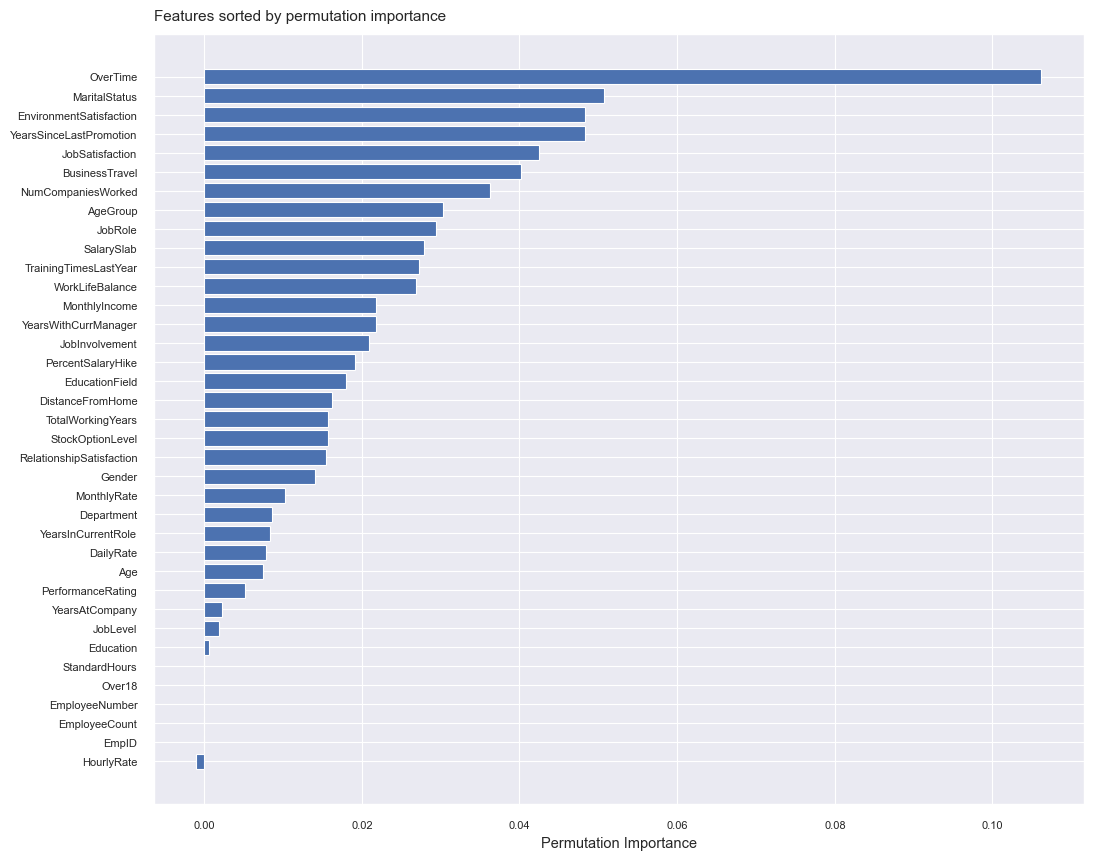

In [12]:
# Estimate feature importance through permutation importance
result = permutation_importance(best_pipe, Xtrain, ytrain, n_repeats=20, random_state=42)
importance_scores = result.importances_mean
original_columns = Xtrain.columns
feature_importance_list = list(zip(original_columns, importance_scores))
sorted_feature_importance = sorted(feature_importance_list, key=lambda x: x[1], reverse=False)
orig_sorted_features, orig_sorted_importance = zip(*sorted_feature_importance)

# Plot it
fig, ax = plt.subplots(figsize=(12,10))
ax.barh(orig_sorted_features, orig_sorted_importance)
ax.set(title='Features sorted by permutation importance',
      xlabel='Permutation Importance')